In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [98]:
## Read pickle data

df_train = pd.read_pickle("./df_train_ts001.pkl")
df_test  = pd.read_pickle("./df_test_ts001.pkl")

## For moving avg
#df_train = pd.read_pickle("./df_train_mvavg_norm_ts001.pkl")
#df_test  = pd.read_pickle("./df_test_mvavg_norm_ts001.pkl")

In [99]:
df_train

,unit,time,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1


# Modeling and Prediction
### Using SGD, RandomForest, SVM-SVR

In [103]:
mod = SGDRegressor()           #r2 score = -0.09
#mod = RandomForestRegressor()   #r2 score = -0.886
#mod = SVR(gamma='scale')         #r2 score = -1.0982420402692572
#mod = LinearRegression()          #-0.22042634578769915

In [104]:
mod.fit(df_train.iloc[:,2:15], df_train.iloc[:,15])
RUL_pred = mod.predict(df_test.iloc[:,2:15])

In [105]:
r2_score(df_test.iloc[:,15], RUL_pred)

-3.614651425997315e+29

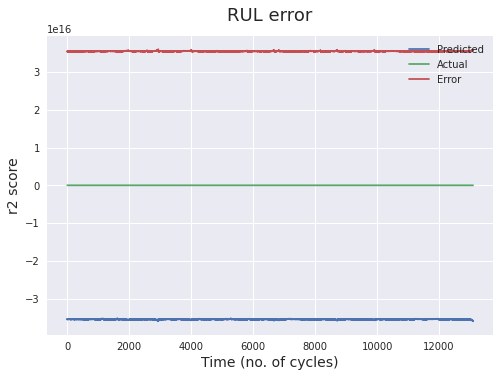

In [106]:
#plot actual vs predicted
plt.plot(RUL_pred, label = 'Predicted')
plt.plot(df_test.iloc[:,15], label = 'Actual')
plt.plot(df_test.iloc[:,15]-RUL_pred, label = 'Error')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Time (no. of cycles)', fontsize = 14)
plt.title('RUL error', fontsize = 18, y = 1.03)
plt.legend()

## Hyperparameter Tuning

In [100]:
#Select best model with optimal hyperparameters


model_params = {
#    'sgd': {
#        'model': SGDRegressor(),
#        'params' : {
#            "alpha": [0.001, 0.01, 0.1, 1, 10],
#            "penalty": ["none", "l1", "l2"]
#        }
#    },    
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators':[100, 150, 200, 300]    #[40, 60, 80, 100]
        }
    },
    'svm':{
        'model': SVR(gamma='auto'),
        'params':{
            'C':[30, 50, 70, 100],           #'C':[1, 10, 20],
            'kernel':['rbf']            #['rbf', 'linear']
        }
    },
    
}


In [101]:
scores = []

for model_name, mp in model_params.items():
    mod = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    mod.fit(np.asarray(df_test.iloc[:,2:15]), df_test.iloc[:,15])
    scores.append({
        'model':model_name,
        'best_score':mod.best_score_,
        'best_params':mod.best_params_
    })

model_params = {
    'sgd': {
        'model': SGDRegressor(),
        'params' : {
            "alpha": [0.001, 0.01, 0.1, 1, 10],
            "penalty": ["none", "l1", "l2"]
        }
    },    
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators':[40, 60, 80, 100]
        }
    },
    'svm':{
        'model': SVR(gamma='auto'),
        'params':{
            'C':[30, 50, 70],          
            'kernel':['rbf']            
        }
    },
    
}


scores:

[{'model': 'sgd',
  'best_score': 0.30072262955114154,
  'best_params': {'alpha': 0.01, 'penalty': 'none'}},
 {'model': 'random_forest',
  'best_score': 0.3351973906172864,
  'best_params': {'n_estimators': 100}},
 {'model': 'svm',
  'best_score': 0.3467897727626246,
  'best_params': {'C': 20, 'kernel': 'rbf'}}]
  
  [{'model': 'random_forest',
  'best_score': 0.3402758573970256,
  'best_params': {'n_estimators': 300}},
 {'model': 'svm',
  'best_score': 0.3469257868327697,
  'best_params': {'C': 70, 'kernel': 'rbf'}}]

In [110]:
scores

[{'model': 'random_forest',
  'best_score': 0.33897313914560145,
  'best_params': {'n_estimators': 200}},
 {'model': 'svm',
  'best_score': 0.28067689236925525,
  'best_params': {'C': 30, 'kernel': 'rbf'}}]

## Best  Model

### SVR, C=70, kernel = rbf


# Learning Curves with the best model

In [108]:
train_sizes=[1.0, 0.75, 0.5, 0.2, 0.1,0.01]
#train_sizes=[100000,20000,5000,1000]
rfr = RandomForestRegressor(n_estimators=200)
train_sizes, train_scores, validation_scores = learning_curve(
estimator = rfr,
train_sizes=train_sizes,
X = df_train.iloc[:,2:15],
y = df_train.iloc[:,15], cv = 3)

In [111]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1 )
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 137      0.952491
1375     0.975330
2750     0.973841
6877     0.957014
10315    0.957697
13754    0.949681
dtype: float64

 --------------------

Mean validation scores

 137      0.348043
1375     0.535245
2750     0.585832
6877     0.581278
10315    0.592187
13754    0.602691
dtype: float64


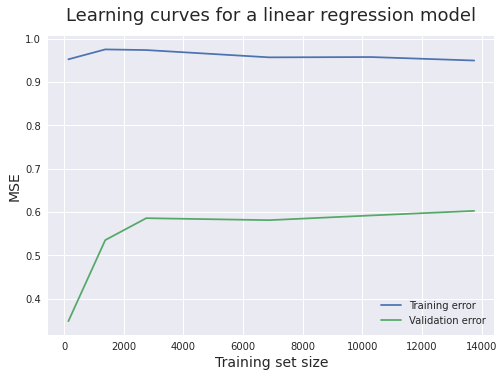

In [112]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
#plt.ylim(0,40)